In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import seaborn as sns
from dask import delayed, compute
import itertools
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pylab as pl
from dask import delayed, compute
# from metpy.calc import pressure_to_height_std as p2h
# from metpy.calc import lcl
# import cartopy.crs as ccrs
# import cartopy
# import cartopy.mpl.ticker as cticker
# import cartopy.io.img_tiles as cimgt
# import cartopy.feature as cfeature
import warnings
# import cython
warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [8]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

In [9]:
# cluster = SLURMCluster(queue="seseml",
#                        memory='50GB',
#                        cores=20,
#                        processes=1,
#                        walltime='24:00:00', 
# #                        scheduler_options={
# #                            'host': '172.22.179.3:7224', 
# #                            'dashboard_address': ':7798'
# #                        }
#                       )

# cluster.scale(jobs=1)
# cluster

In [10]:
# client = Client(cluster)
# client

In [11]:
# %%bash
# squeue -u $USER

In [12]:
cluster = LocalCluster()  
cluster

LocalCluster(773063d2, 'tcp://127.0.0.1:40059', workers=8, threads=48, memory=48.00 GiB)

In [13]:
aircraft = 'Lear'
aircraft2 = 'Learjet'
aircraft1 = 'P3B'
aircraft3 = 'P3B'

In [14]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr_merged.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store11 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr_merged.zarr"
store

'/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/zarr/dm_retrieved_Lear_corr_merged.zarr'

In [15]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)

In [16]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

In [17]:
new_cols = ['dbz_t_ka', 'dbz_t_ku', 'Att_ku', "Att_ka", 'nt', 'lwc_cum', 'mu', 'new_mu', 'mu3', 'mu_bf','sigma', 'sigmap', 'dm', 
            'log10_nw', 'r', 'dfr', 'temp', 'vert_vel', 'altitude','z_ku_mu1', 'z_ku_mu2', 'z_ku_mu3', 'z_ku_mu_bf',
            'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3', 'z_ka_mu_bf', 'lon', 'lat']

In [21]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [22]:
ds_pca = ds[['sigma', 'sigmap', 'dm', 'log10_nw', 'mu', 'r', 'dfr', 'dbz_t_ka', 'dbz_t_ku', 'nt', 'lwc_cum', 'temp', 'vert_vel', 'altitude', "new_mu"]]
ds_pca['logr'] = np.log10(ds.r)
ds_pca['lognt'] = np.log10(ds.nt)
ds_pca['loglwc'] = np.log10(ds.lwc_cum)

In [24]:
df = ds_pca.to_dataframe().reset_index()

In [25]:
scaler = StandardScaler()
df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

In [26]:
n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=10)

In [27]:
df['kmeans_6'] = kmeans.labels_

In [28]:
from matplotlib.colors import ListedColormap

# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap6 = ListedColormap(sns.color_palette(flatui).as_hex())

colors6 = my_cmap6(np.linspace(0,1,n_c))

In [29]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})

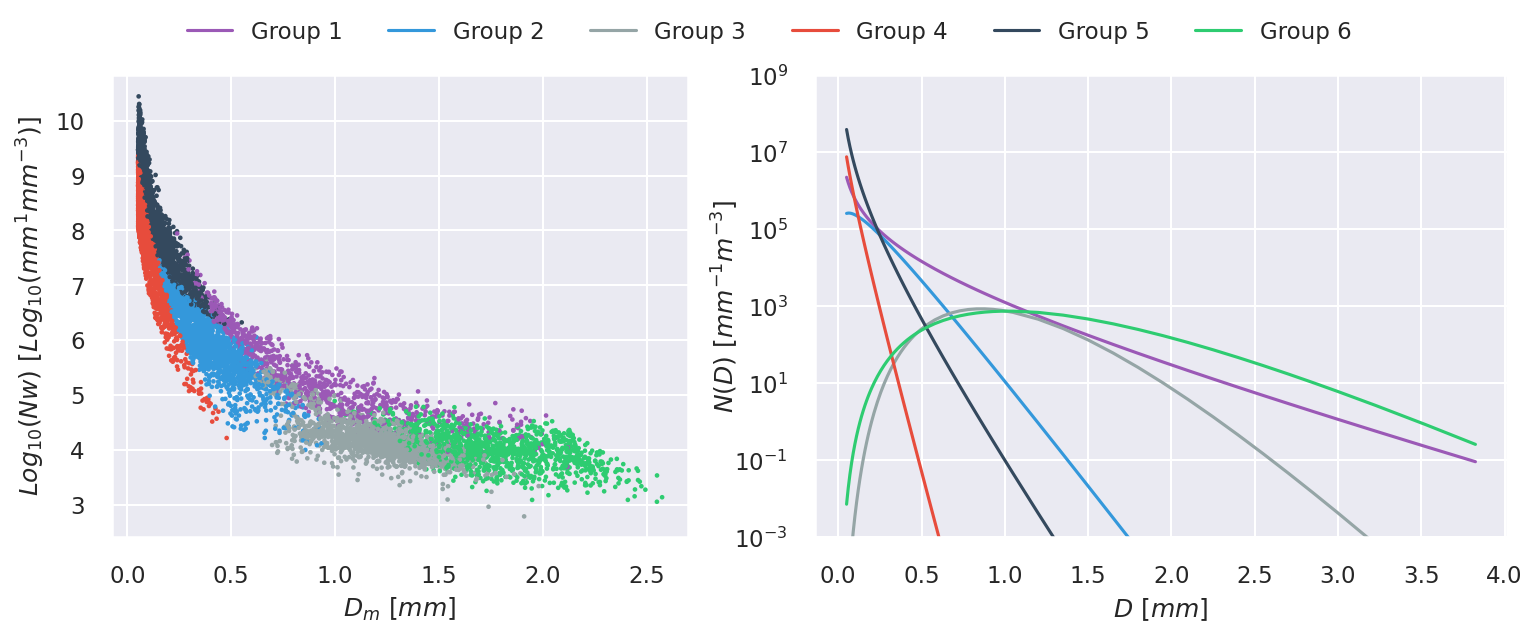

In [33]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
# fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

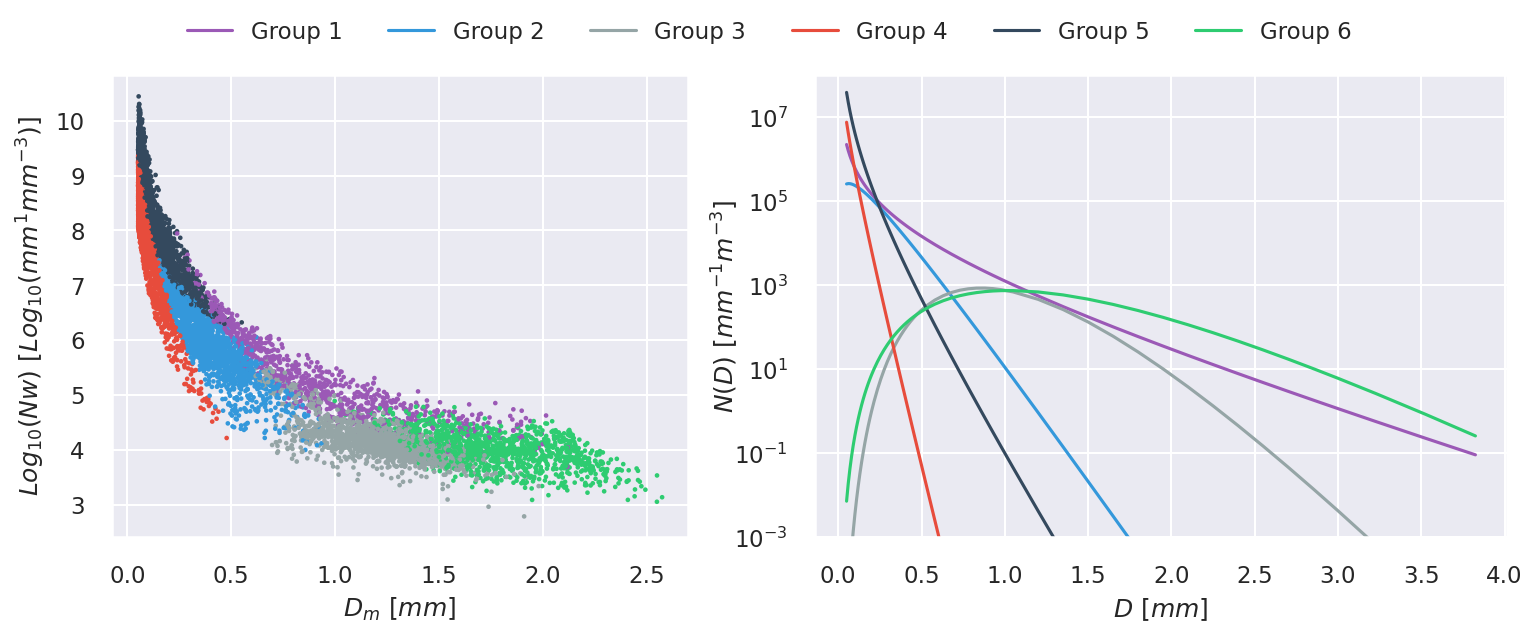

In [36]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
# fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(0.5)
    dm = df_sub['dm'].quantile(0.5)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

# plots 

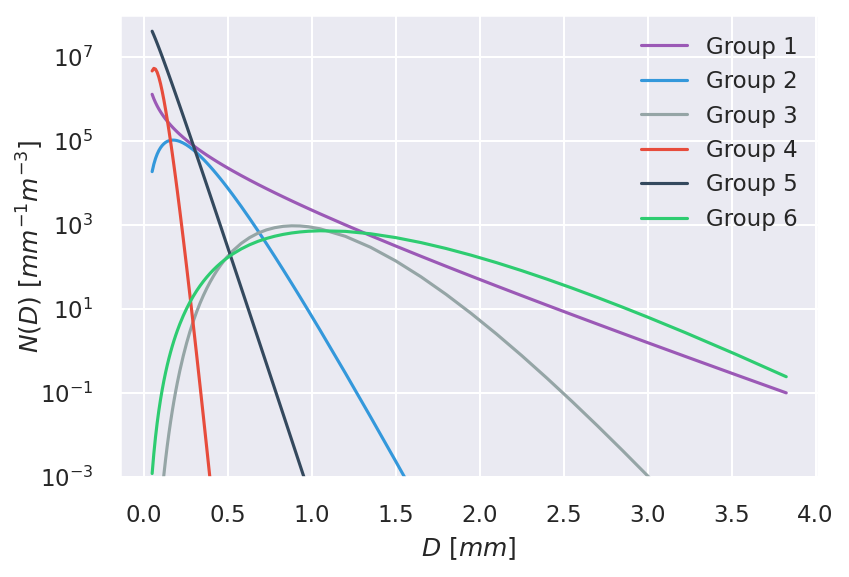

In [39]:
fig, ax1 = plt.subplots(figsize=(6,4), dpi=150)
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
ax1.legend()

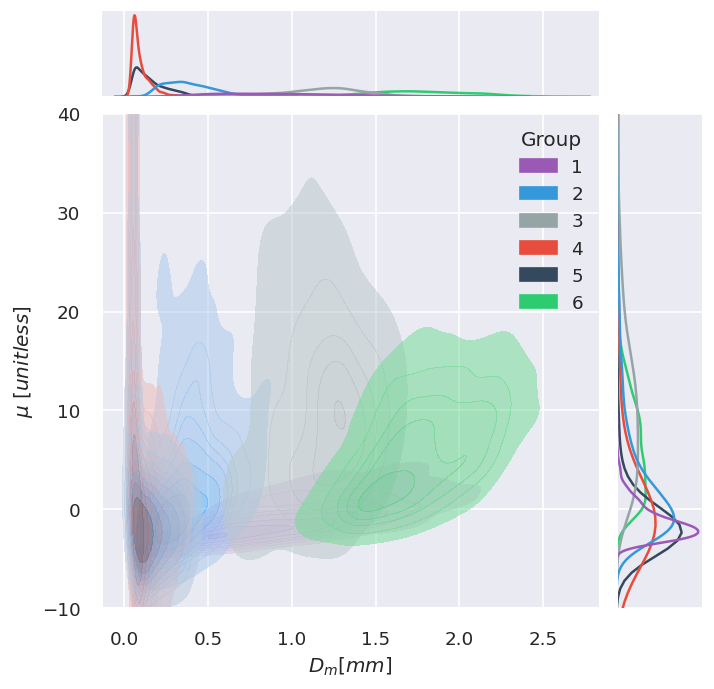

In [40]:
# df =  df[(df['mu'] < 20)]
labels = ['1', '2', '3', '4', '5', '6']
p = sns.jointplot(data=df.rename(columns={"kmeans_6": "Group"}).replace({i: i + 1 for i in df.rename(columns={"kmeans_6": "Group"})['Group'].unique()}), 
                  x="dm", y="mu", kind="kde", hue="Group", palette=sns.color_palette(flatui).as_hex(), 
                  shade=True, alpha=.5,)
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
p.ax_marg_y.set_ylim(-10, 40)
# p._legend.remove()
ax = plt.gca()
plt.show()

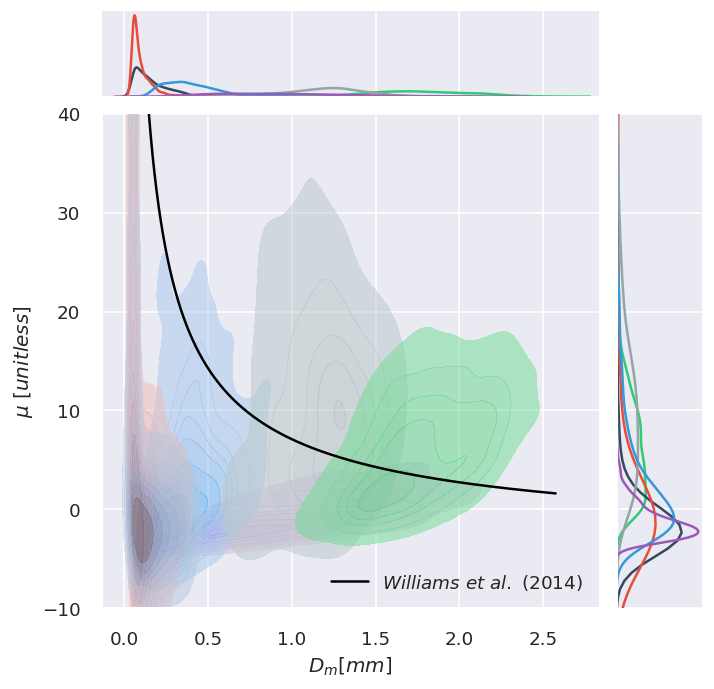

In [41]:
# df =  df[(df['mu'] < 20)]
labels = ['1', '2', '3', '4', '5', '6']
df['mu_dm'] = 11.1 * df['dm'] ** (-0.72) - 4
p = sns.jointplot(data=df.rename(columns={"kmeans_6": "Group"}).replace({i: i + 1 for i in df.rename(columns={"kmeans_6": "Group"})['Group'].unique()}), 
                  x="dm", y="mu", kind="kde", hue="Group", palette=sns.color_palette(flatui).as_hex(), 
                  shade=True, alpha=.5, legend='auto')
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
p.ax_marg_y.set_ylim(-10, 40)
ln = sns.lineplot(data=df, x='dm', y='mu_dm',color='black', ax=p.ax_joint, label=r"$Williams \ et \ al. \ (2014)$", legend='full')
sns.move_legend(ln, 'lower right')
# p._legend.remove()
ax = plt.gca()
plt.show()

In [43]:
br = np.arange(0.5, 5.5, 0.001)
# _res = np.zeros_like(br)
res = np.zeros_like(br)
for i in range(br.shape[0]):
    res[i] = np.corrcoef(df['dm'], df['sigma'] / df['dm'] ** br[i])[0, 1] ** 2
bm = br[np.argmin(res)]

In [44]:
df['mu_camp2ex'] = ((df['dm'] ** (2 - 2 * bm)) / (df['sigmap'].mean() ** 2)) - 4

In [45]:
df['mu_williams'] = 11.1 * df['dm'] ** (-0.72) - 4

In [46]:
def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return

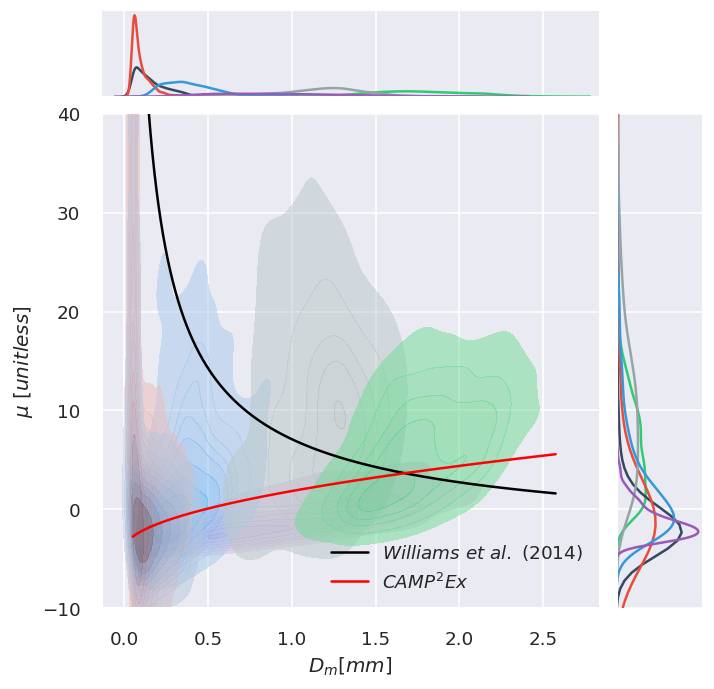

In [47]:
# df =  df[(df['mu'] < 20)]
labels = ['1', '2', '3', '4', '5', '6']
df['mu_dm'] = 11.1 * df['dm'] ** (-0.72) - 4
p = sns.jointplot(data=df.rename(columns={"kmeans_6": "Group"}).replace({i: i + 1 for i in df.rename(columns={"kmeans_6": "Group"})['Group'].unique()}), 
                  x="dm", y="mu", kind="kde", hue="Group", palette=sns.color_palette(flatui).as_hex(), 
                  shade=True, alpha=.5, legend='auto')
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
p.ax_marg_y.set_ylim(-10, 40)
ln = sns.lineplot(data=df, x='dm', y='mu_dm',color='black', ax=p.ax_joint, label=r"$Williams \ et \ al. \ (2014)$", legend='full')
ln2 = sns.lineplot(data=df, x='dm', y='mu_camp2ex',color='red', ax=p.ax_joint, label=r"$CAMP^{2}Ex$")
sns.move_legend(ln, 'lower right')
# p._legend.remove()
ax = plt.gca()
plt.show()

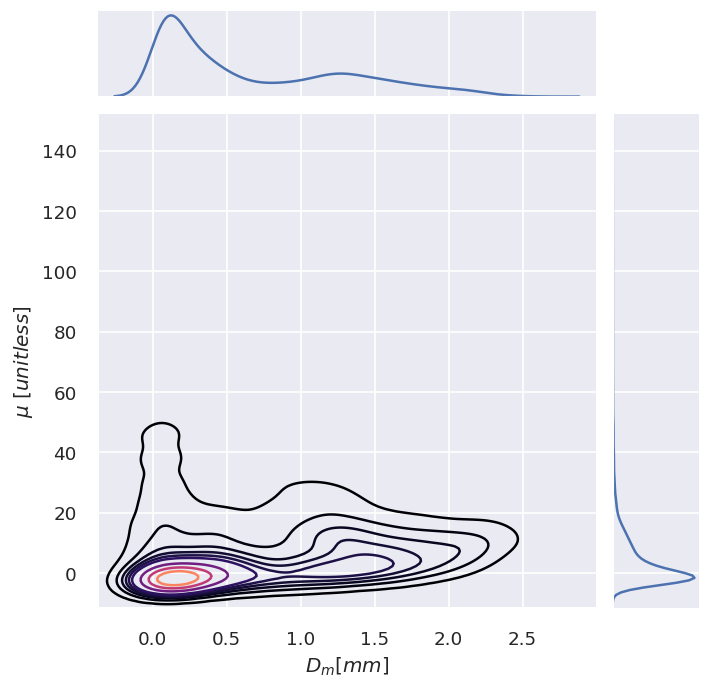

In [48]:
# df = ds[['dm', 'new_mu']].to_dataframe().reset_index()
# df = df.replace([np.inf, -np.inf], np.nan).dropna()
# df =  df[(df['new_mu'] < 20)]
p = sns.jointplot(data=df, x="dm", y="mu", kind="kde", cmap='magma')
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
# p.ax_marg_y.set_ylim(-10, 40)
plt.show()

Text(0, 0.5, '$\\sigma \\ [mm] $')

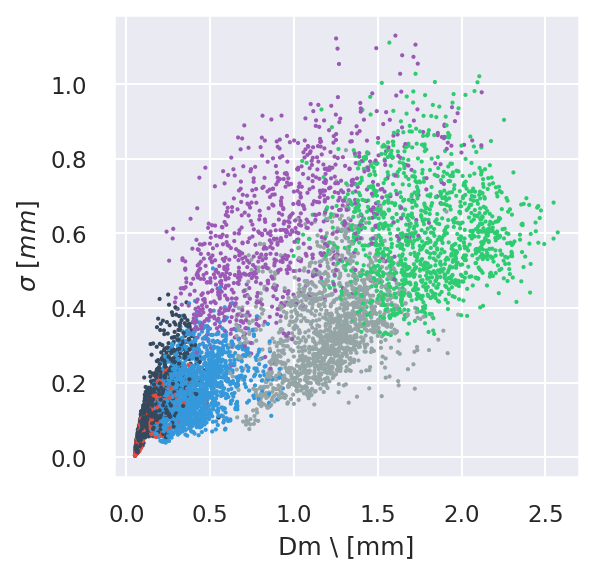

In [49]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.sigma, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm \ [mm]")
ax.set_ylabel(r"$\sigma \ [mm] $")

Text(0, 0.5, '$Log_{10}(R) \\ [Log_{10}(mm hr^{-1})]$')

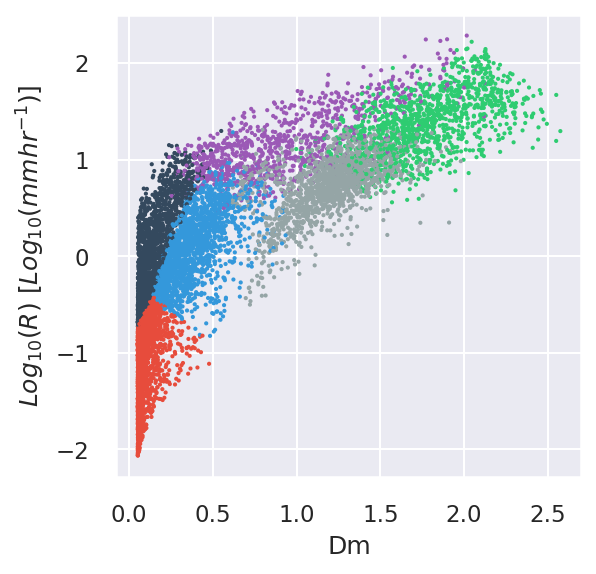

In [50]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.logr, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Log_{10}(R) \ [Log_{10}(mm hr^{-1})]$")

(0.005219554861448538, 200)

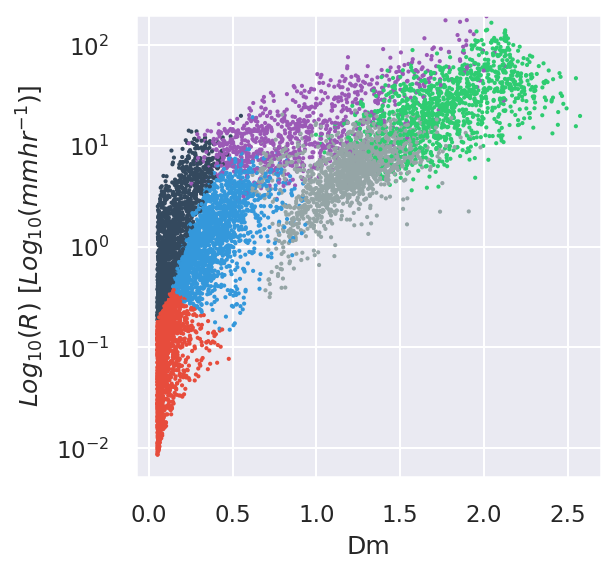

In [51]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.r, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Log_{10}(R) \ [Log_{10}(mm hr^{-1})]$")
ax.set_yscale('log')
ax.set_ylim(0, 200)

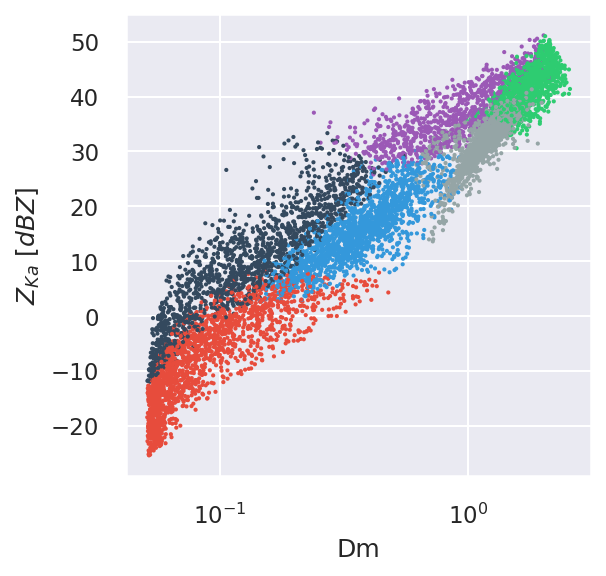

In [52]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.dbz_t_ka, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Z_{Ka} \ [dBZ]$")
# ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_ylim(0, 200)

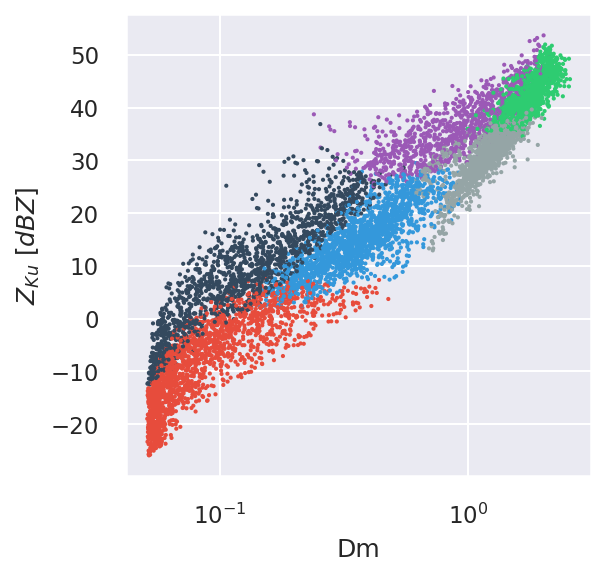

In [53]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.dbz_t_ku, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Z_{Ku} \ [dBZ]$")
ax.set_xscale('log')
# ax.set_ylim(0, 200)

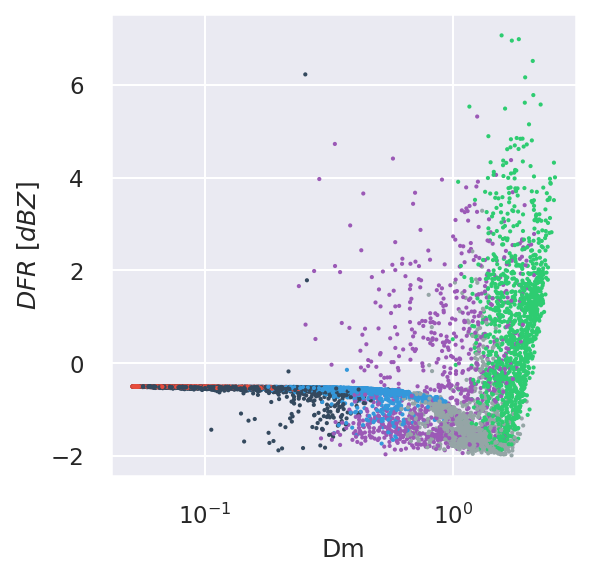

In [54]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.dbz_t_ku - df.dbz_t_ka, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$DFR \ [dBZ]$")
ax.set_xscale('log')
# ax.set_ylim(0, 200)

Text(0, 0.5, '$Log_{10}(Nt)$')

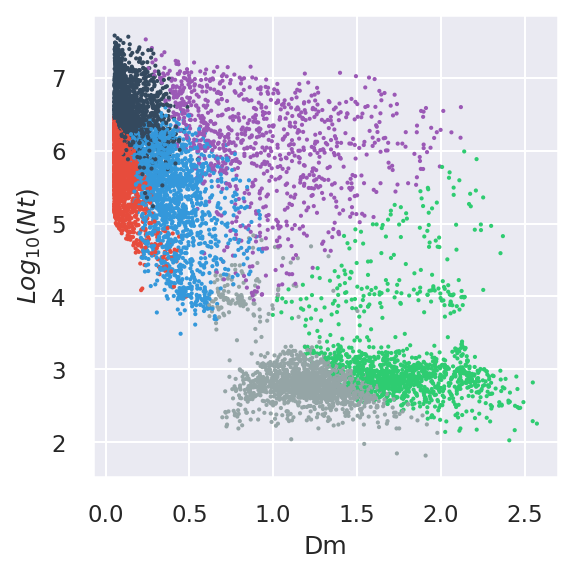

In [55]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.lognt, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Log_{10}(Nt)$")
# ax.set_yscale('log')
# ax.set_ylim(0, 200)

(0.0, 10.0)

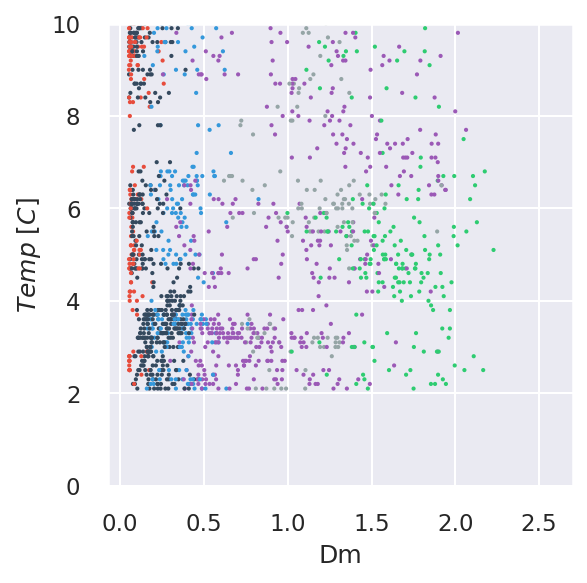

In [56]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter( df.dm, df.temp,c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Temp \ [C]$")
# ax.set_yscale('log')
ax.set_ylim(0, 10)

Text(0, 0.5, '$Temp \\ [C]$')

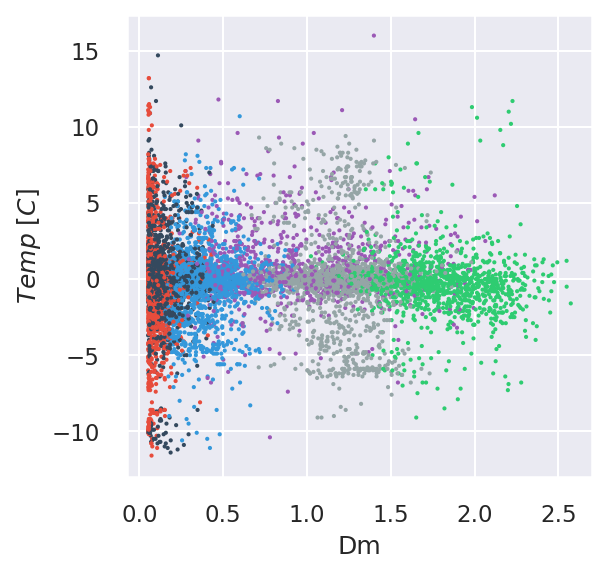

In [57]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.vert_vel, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Temp \ [C]$")
# ax.set_yscale('log')
# ax.set_ylim(0, 10)

Text(0, 0.5, '$Altitude \\ [ft]$')

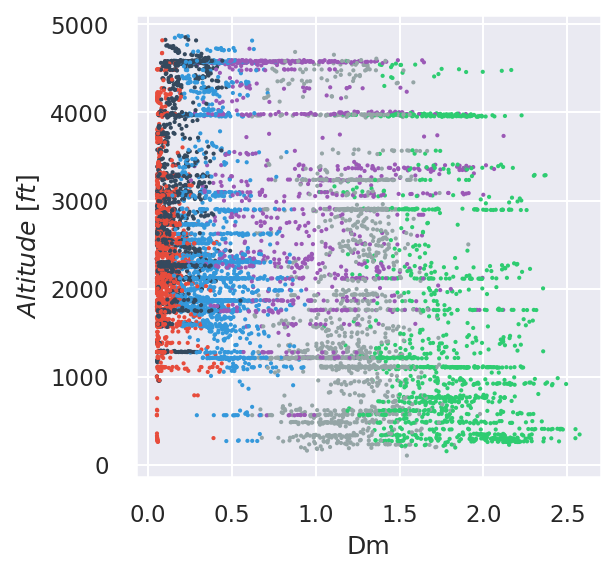

In [58]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(df.dm, df.altitude, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("Dm")
ax.set_ylabel(r"$Altitude \ [ft]$")
# ax.set_yscale('log')
# ax.set_ylim(0, 10)

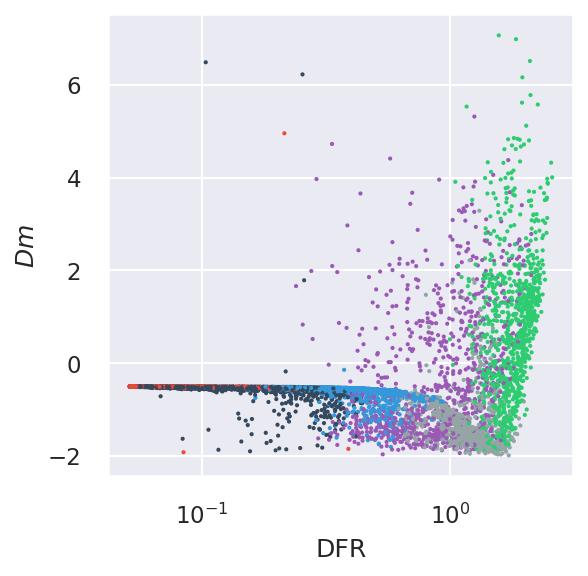

In [59]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter( df.dm, df.dfr, c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("DFR")
ax.set_ylabel(r"$Dm$")
ax.set_xscale('log')
# ax.set_ylim(0, 10)

# Scores

In [60]:
def get_kmeans_score(df, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(df)
    model2 = kmeans.fit_predict(df)
    cluster_labels = model.labels_
    
    dav = davies_bouldin_score(df, model2)
    sil = silhouette_score(df, cluster_labels)
    elbow = model.inertia_
    return dav, sil, elbow

dav = []
sil = []
elbow = []


for center in range(2,15):
    _dav, _sil, _el = get_kmeans_score(df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]], center)
    dav.append(_dav)
    sil.append(_sil)
    elbow.append(_el)


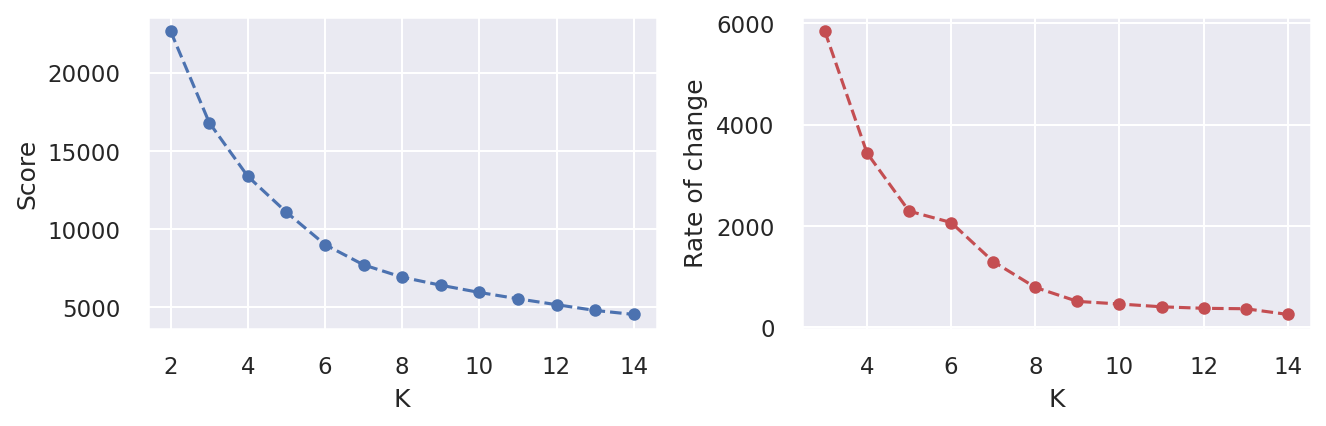

In [61]:
centers = range(2,15)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(9, 3), dpi=150)
ax.plot(centers, elbow, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax1.plot(centers[1:], np.array(elbow[:-1]) - np.array(elbow[1:]) , linestyle='--', marker='o', color='r');
# ax1.bar(centers[1:], height=np.array(elbow[:-1]) - np.array(elbow[1:]));

ax1.set_xlabel('K');
ax1.set_ylabel('Rate of change');
plt.tight_layout()

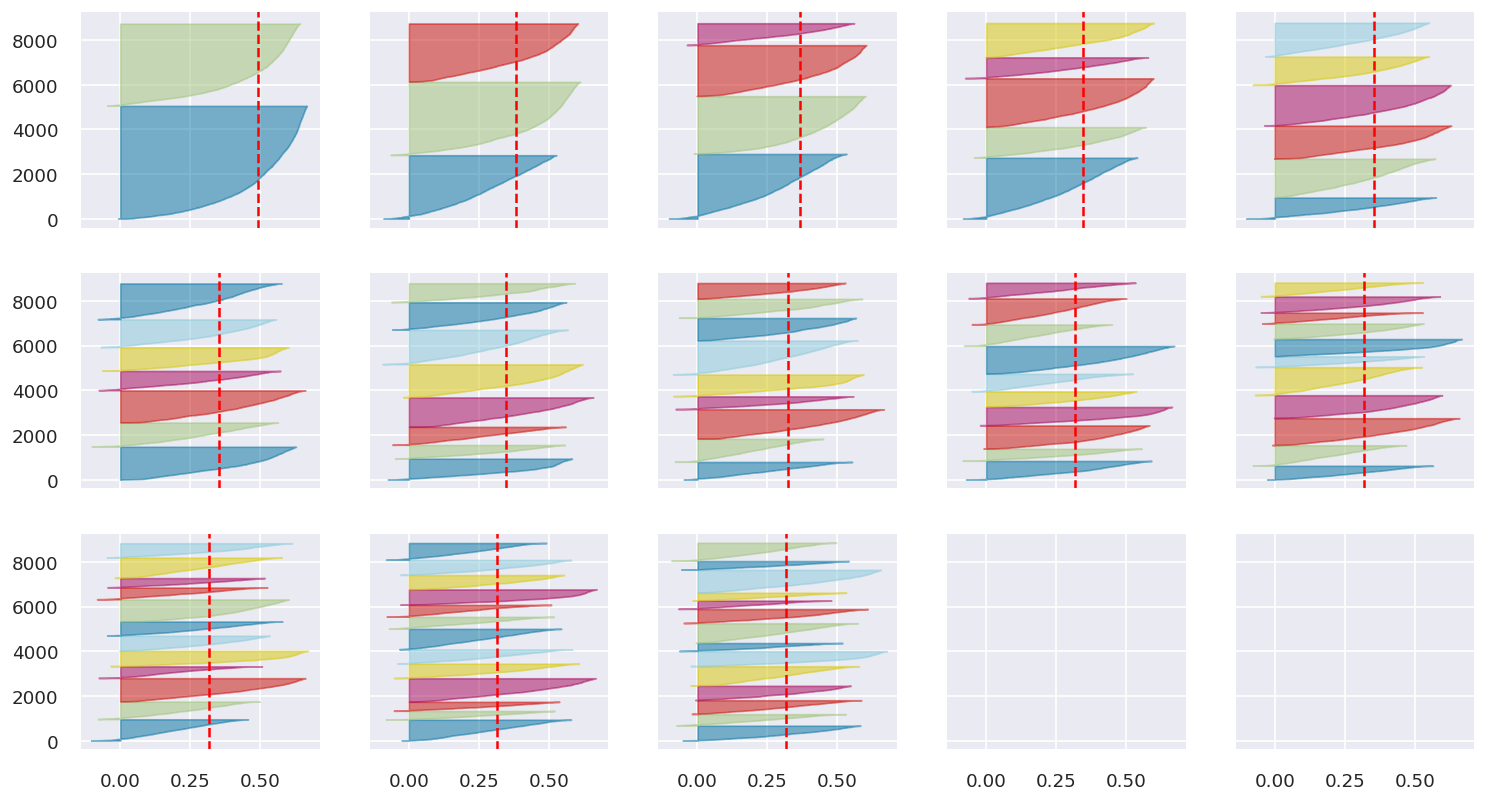

In [62]:
fig, axs = plt.subplots(3, 5, figsize=(15,8), sharex=True, sharey=True)
centers = np.arange(2, 15)
for idx, ax in enumerate(axs.flat):
    '''
    Create KMeans instance for different number of clusters
    '''
    try:
        km = KMeans(n_clusters=centers[idx]) # , init='k-means++', n_init=10, max_iter=100, random_state=42)
        '''
        Create SilhouetteVisualizer instance with KMeans instance
        Fit the visualizer
        '''
        visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax)
        visualizer.fit(X)
    except IndexError:
        pass

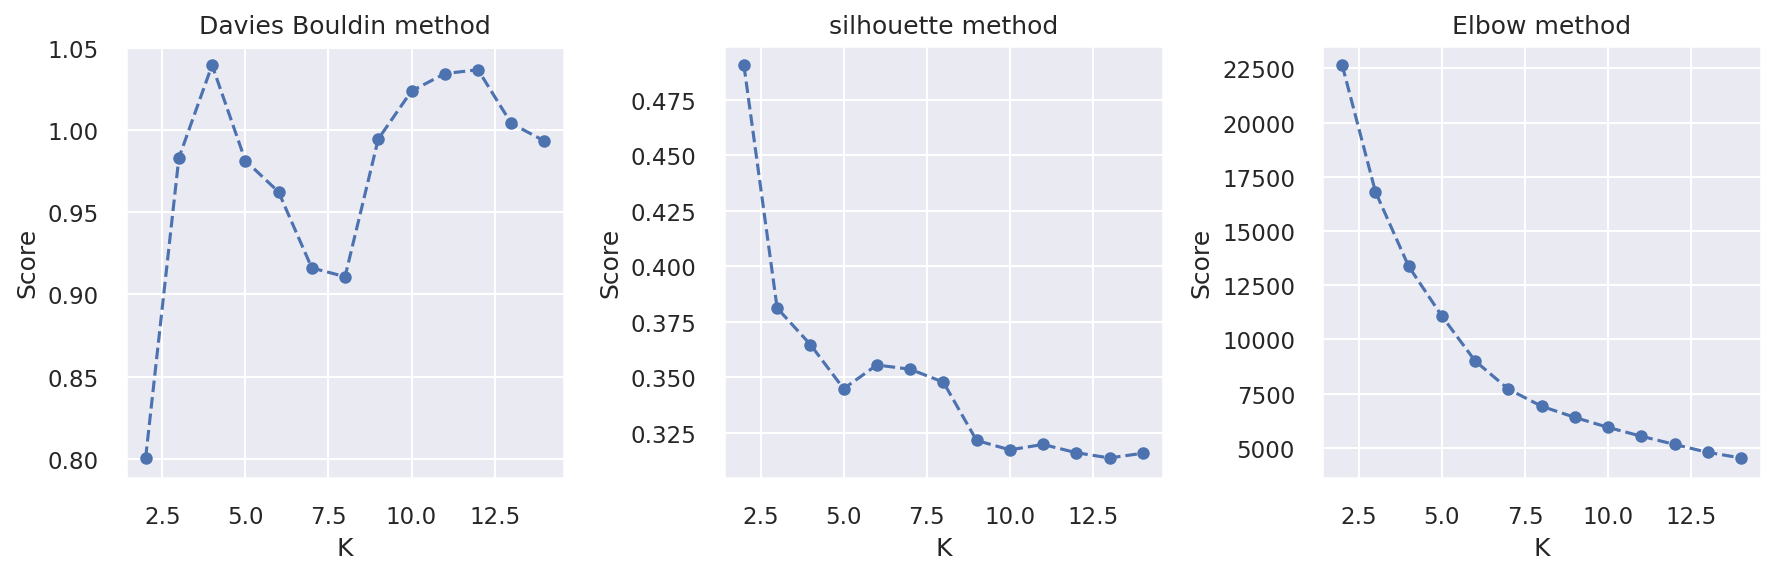

In [63]:
centers = range(2,15)
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
ax.plot(centers, dav, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax.set_title('Davies Bouldin method');

ax1.plot(centers, sil, linestyle='--', marker='o', color='b');
ax1.set_xlabel('K');
ax1.set_ylabel('Score');
ax1.set_title('silhouette method');

ax2.plot(centers, elbow, linestyle='--', marker='o', color='b');
ax2.set_xlabel('K');
ax2.set_ylabel('Score');
ax2.set_title('Elbow method');
fig.tight_layout()

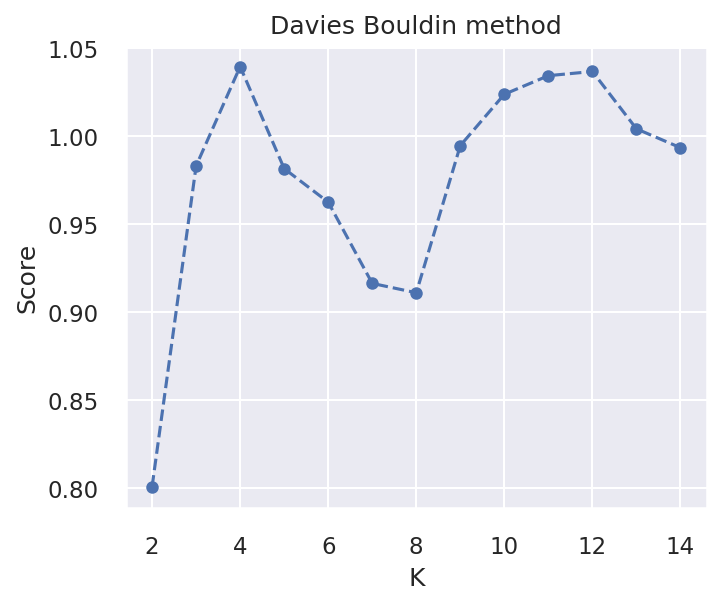

In [64]:
centers = range(2,15)
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
ax.plot(centers, dav, linestyle='--', marker='o', color='b');
ax.set_xlabel('K');
ax.set_ylabel('Score');
ax.set_title('Davies Bouldin method');

In [65]:
pca = PCA(0.90)
df[['PCA1', 'PCA2']] = pca.fit_transform(X)

In [66]:
g1 = df[(df.PCA1 > 1.5) & (df.PCA2 > -1.5)  & (df.PCA2 < 1.5)]
df.loc[(df.PCA1 > 1.5) & (df.PCA2 > -1.5)  & (df.PCA2 < 1.5), 'Group_PCA'] = 1
g2 = df[(df.PCA1 > -4.5) & (df.PCA1 < -1.5)]
df.loc[(df.PCA1 > -4.5) & (df.PCA1 < -1.5), 'Group_PCA'] = 2
g3 = df[(df.PCA2 > 1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5)]
df.loc[(df.PCA2 > 1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5), 'Group_PCA'] = 3
g4 = df[(df.PCA2 < -1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5)]
df.loc[(df.PCA2 < -1.5)& (df.PCA1 > -1.5) & (df.PCA1 < 1.5), 'Group_PCA'] = 4
g5 = df[(df.PCA2 > 1.5)& (df.PCA1 > 1.5)]
df.loc[(df.PCA2 > 1.5)& (df.PCA1 > 1.5), 'Group_PCA'] = 5
g6 = df[(df.PCA2 < -1.5)& (df.PCA1 > 1.5)]
df.loc[(df.PCA2 < -1.5)& (df.PCA1 > 1.5), 'Group_PCA'] = 6
gn = df[(df.PCA2 > -1.5) & (df.PCA2 < 1.5) & (df.PCA1 > -1.5) & (df.PCA1 < 1.5)]
df.loc[(df.PCA2 > -1.5) & (df.PCA2 < 1.5) & (df.PCA1 > -1.5) & (df.PCA1 < 1.5), 'Group_PCA'] = 7

In [67]:
ls_gr = [g1, g2, g3, g4, g5, g6]

In [69]:
dm1, mu1, nw1 = g1['dm'].mean(), g1['mu'].mean(), 10 ** (g1['log10_nw']).mean()
gm1 = norm_gamma(d, nw=nw1, mu=mu1, dm=dm1)

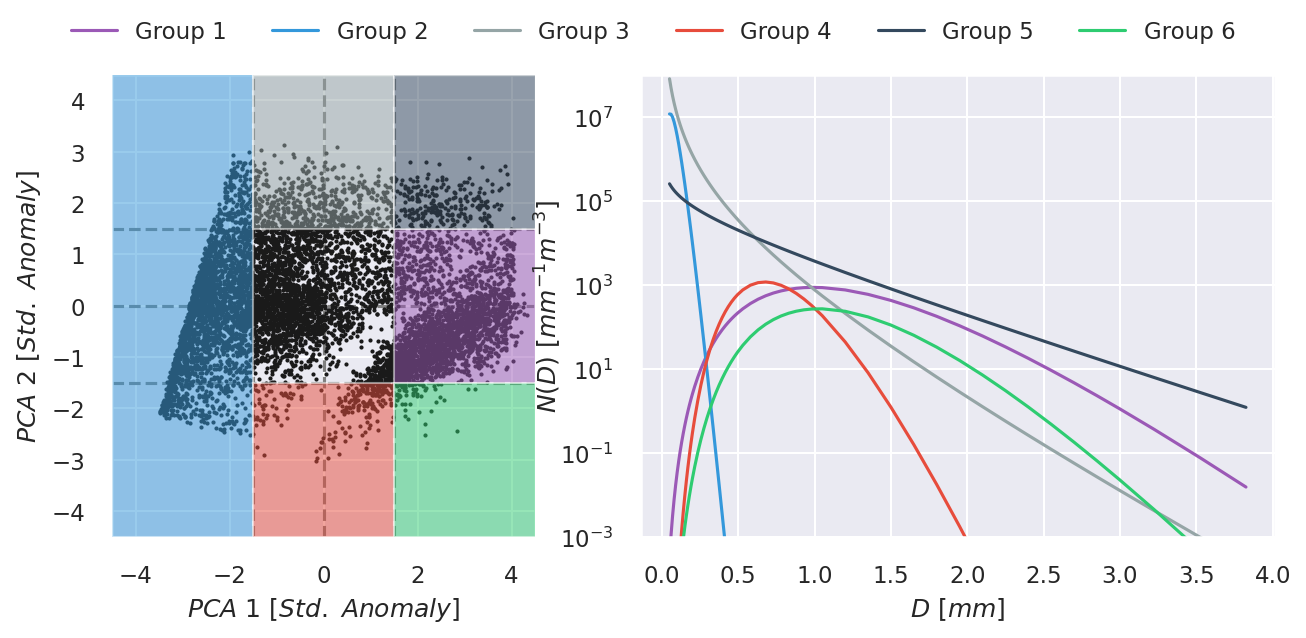

In [70]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10,4), dpi=150, gridspec_kw={'width_ratios': [1, 1.5]})
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = len(ls_gr)
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-2)
ax1.set_xlabel("$D\ [mm]$")
for idx, i in enumerate(ls_gr):
    dm, mu, nw = i['dm'].mean(), i['mu'].mean(), 10 ** (i['log10_nw']).mean()
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[idx], label=f"Group {idx + 1}")
# ax1.legend()

ax.scatter(df.PCA1, df.PCA2, s=1, zorder=10, c='k')
ax.axvline(x=0, ls="--", c='grey', lw=1.5)
ax.axvline(x=1.5, ls="--",  c='grey', lw=1.5)
ax.axvline(x=-1.5, ls="--",  c='grey', lw=1.5)
ax.axhline(y=0, ls="--",  c='grey', lw=1.5)
ax.axhline(y=1.5, ls="--",  c='grey', lw=1.5)
ax.axhline(y=-1.5, ls="--",  c='grey', lw=1.5)

# group 1
rect = plt.Rectangle((1.5,-1.5), 4.5, 3,
                     facecolor=colors6[0], alpha=0.5, zorder=10)
ax.add_patch(rect)

# group 2
rect5 = plt.Rectangle((-4.5, -4.5), 3, 10,
                     facecolor=colors6[1], alpha=0.5, zorder=10)
ax.add_patch(rect5)

# group 3
rect4 = plt.Rectangle((-1.5, 1.5), 3, 3,
                     facecolor=colors6[2], alpha=0.5, zorder=10)

ax.add_patch(rect4)

# group 4
rect3 = plt.Rectangle((-1.5,-4.5), 3, 3,
                     facecolor=colors6[3], alpha=0.5, zorder=10)
ax.add_patch(rect3)

# group 5
rect1 = plt.Rectangle((1.5,1.5), 3.5, 3,
                     facecolor=colors6[4], alpha=0.5, zorder=10)
ax.add_patch(rect1)

#group 6
rect2 = plt.Rectangle((1.5,-4.5), 3.5, 3,
                     facecolor=colors6[5], alpha=0.5, zorder=10)
ax.add_patch(rect2)

ax.set_xlabel(r"$PCA \ 1 \ [Std. \ Anomaly]$")
ax.set_ylabel(r"$PCA \ 2 \ [Std. \ Anomaly]$")
ax.set_ylim(-4.5, 4.5)
ax.set_xlim(-4.5, 4.5)
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)
# fig.tight_layout()

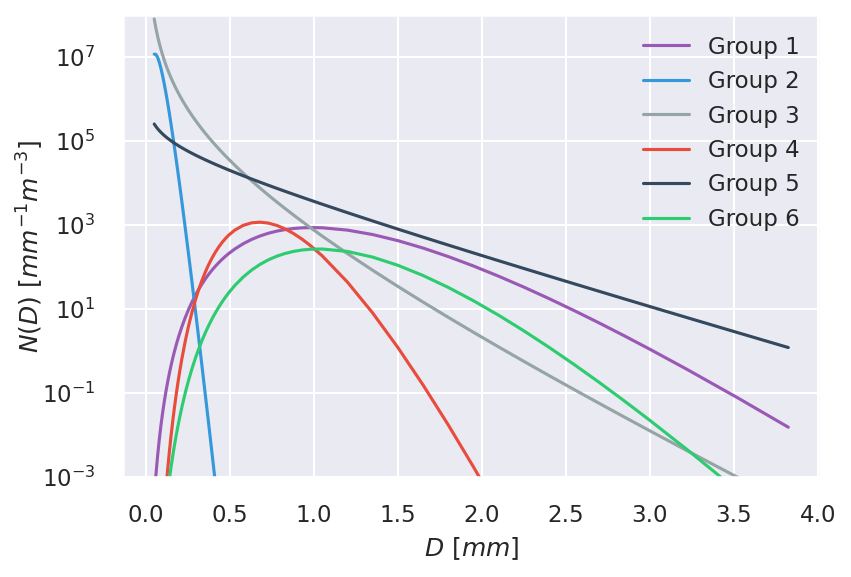

In [71]:
fig, ax1 = plt.subplots(figsize=(6,4), dpi=150)
ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = len(ls_gr)
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-2)
ax1.set_xlabel("$D\ [mm]$")
for idx, i in enumerate(ls_gr):
    dm, mu, nw = i['dm'].mean(), i['mu'].mean(), 10 ** (i['log10_nw']).mean()
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[idx], label=f"Group {idx + 1}")
ax1.legend()

In [72]:
from matplotlib.colors import ListedColormap

# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#FFFF00"]
my_cmap7 = ListedColormap(sns.color_palette(flatui).as_hex())
n=7
colors7 = my_cmap7(np.linspace(0,1,n))

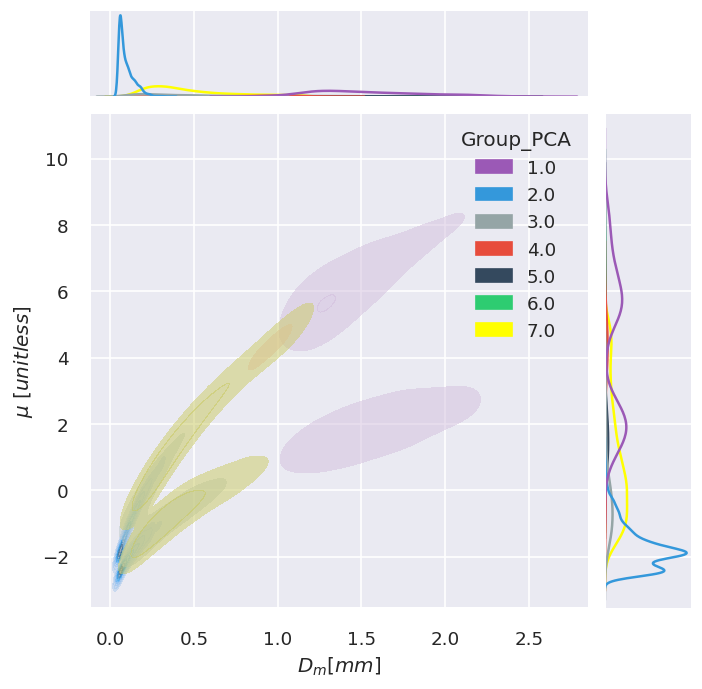

In [73]:
labels = ['1', '2', '3', '4', '5', '6', "7"]
p = sns.jointplot(data=df, 
                  x="dm", y="new_mu", kind="kde", hue="Group_PCA", palette=sns.color_palette(flatui).as_hex(), 
                  shade=True, alpha=.5,)
p.fig.subplots_adjust(top=0.95)
p.set_axis_labels(r"${D_m [mm]}$", r"${\mu \  [unitless]}$",)
# p.ax_marg_y.set_ylim(-75, 75)
# p._legend.remove()
ax = plt.gca()
plt.show()

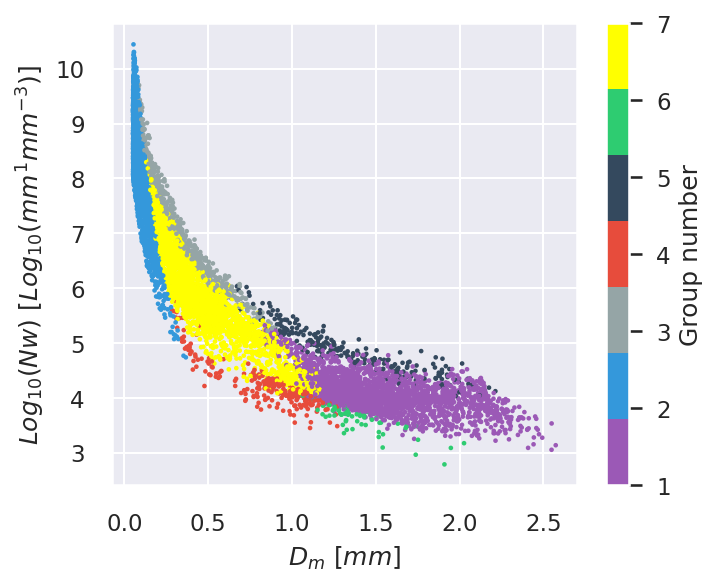

In [74]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["Group_PCA"], s=1.5, cmap=my_cmap7)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")



In [75]:
from sklearn.cluster import Birch, DBSCAN, MiniBatchKMeans, MeanShift, OPTICS, SpectralClustering

In [76]:
model = Birch(threshold=0.01, n_clusters=6)
model.fit(X)

Birch(n_clusters=6, threshold=0.01)

In [77]:
df['birch_g'] = model.predict(X)

In [78]:
silhouette_score(X, df['birch_g'])

0.3203076930275439

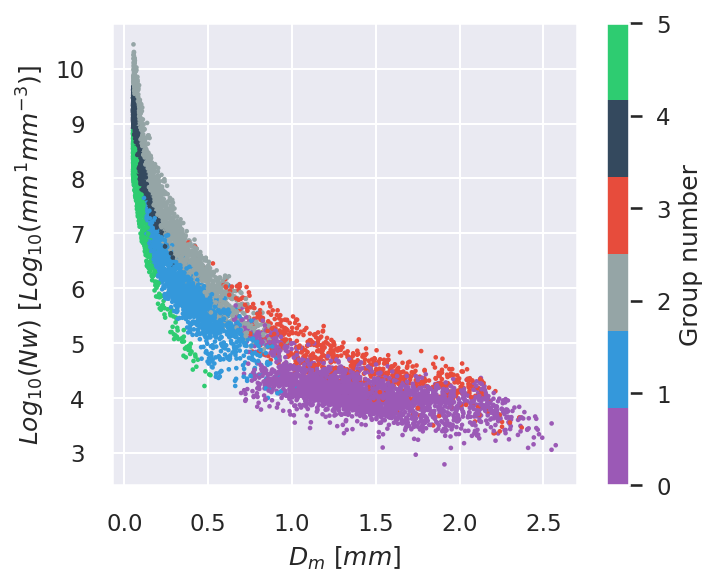

In [79]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["birch_g"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")


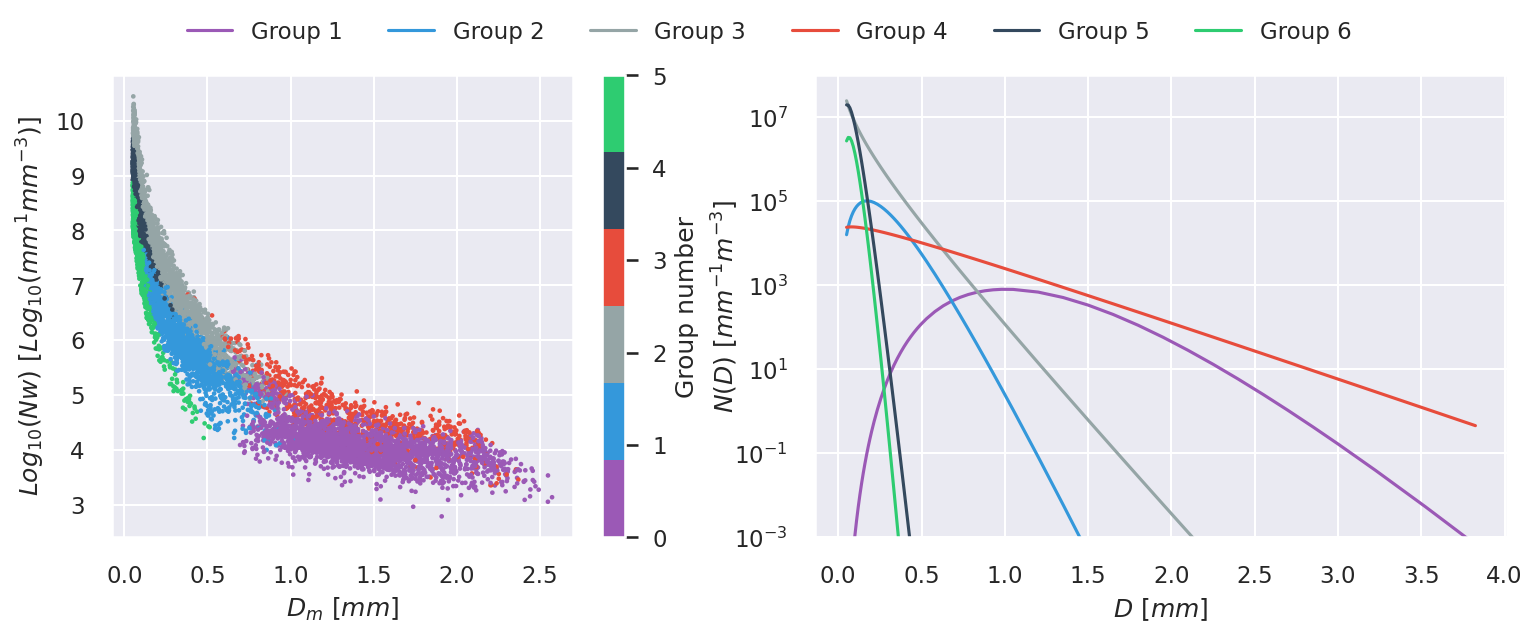

In [82]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['birch_g'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['birch_g'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [83]:
model = DBSCAN(eps=0.30, min_samples=500)
# fit model and predict clusters
df['dbscan_g'] = model.fit_predict(X)

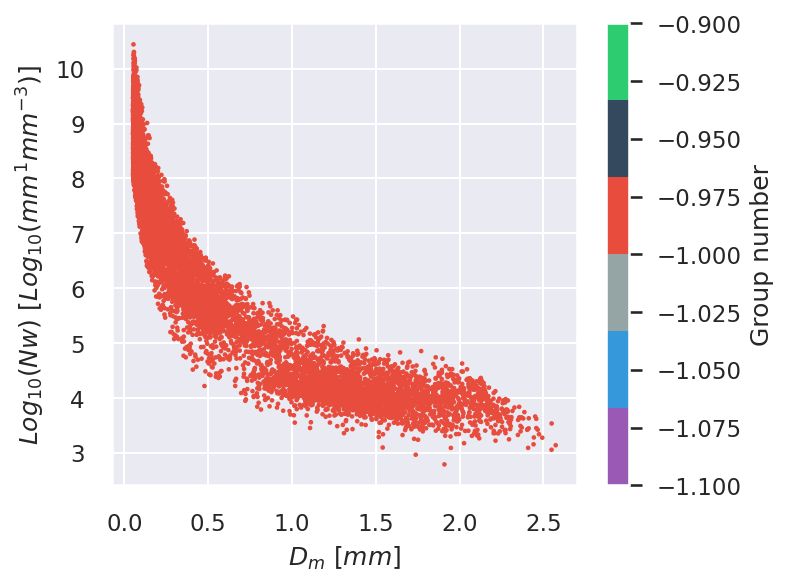

In [84]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["dbscan_g"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

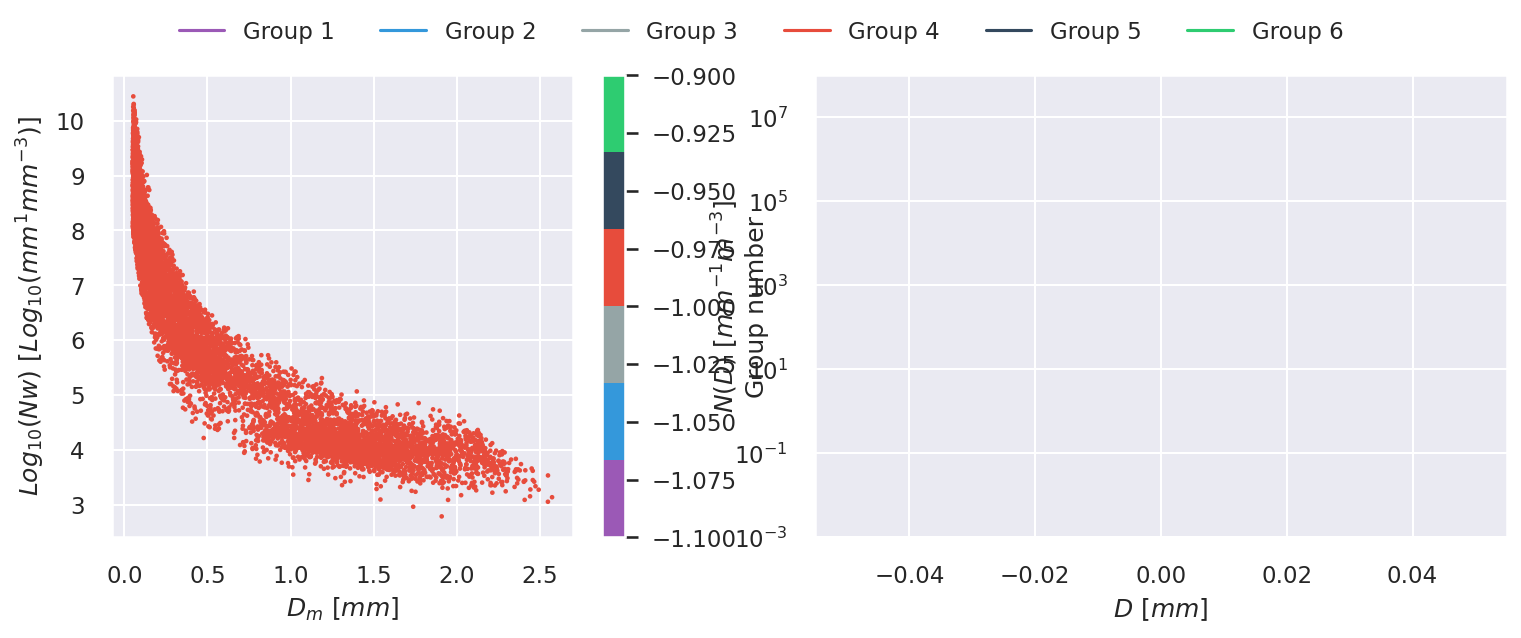

In [87]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['dbscan_g'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['dbscan_g'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [88]:
model = MiniBatchKMeans(n_clusters=6)
# fit the model
model.fit(X)
df['Mb_kmeans'] = model.predict(X)

In [89]:
davies_bouldin_score(X, df['Mb_kmeans'])
silhouette_score(X, df['Mb_kmeans'])

0.3532468009833182

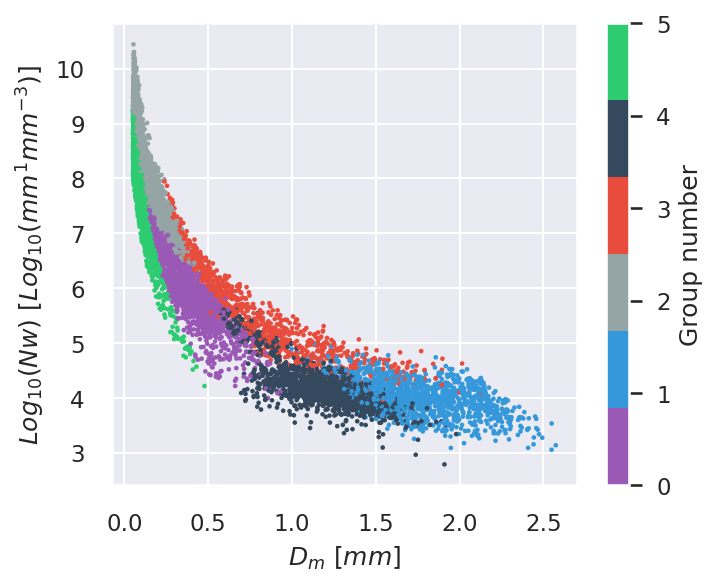

In [90]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["Mb_kmeans"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

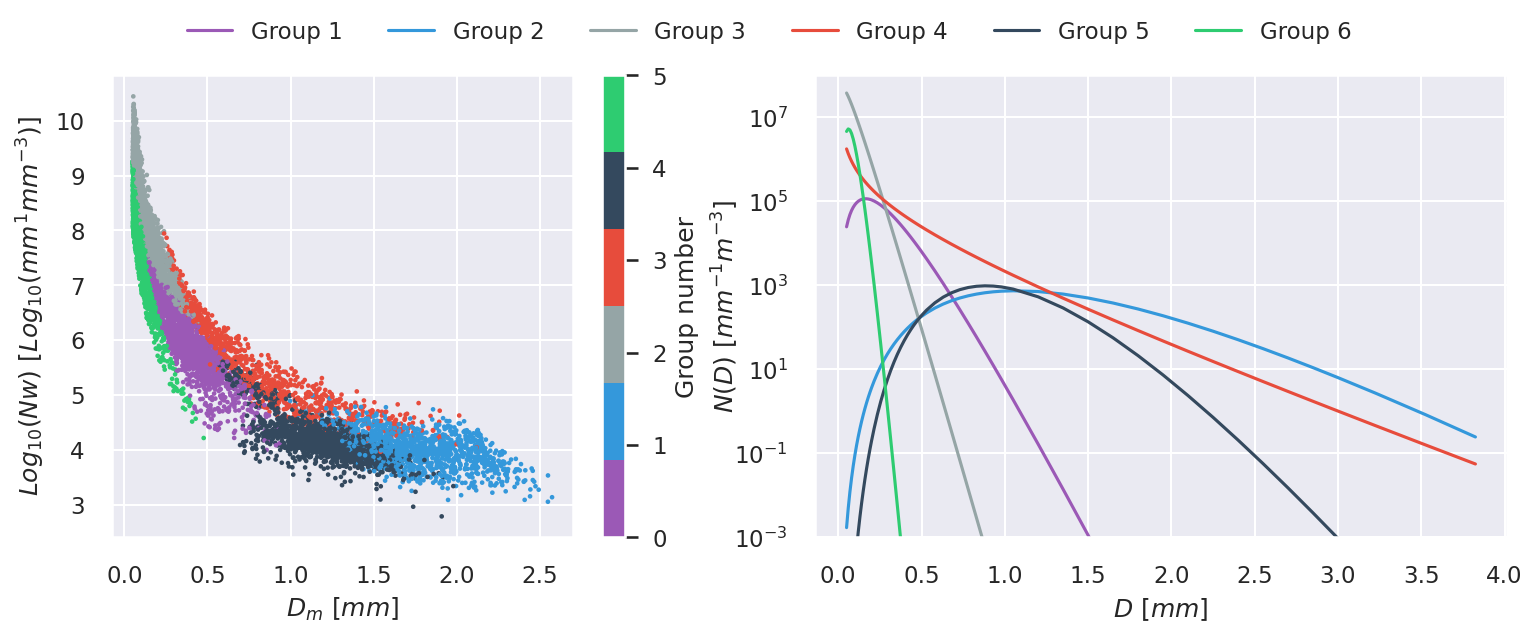

In [92]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['Mb_kmeans'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['Mb_kmeans'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [93]:
model = MeanShift()
# fit model and predict clusters
df['mean_shift'] = model.fit_predict(X)

In [94]:
davies_bouldin_score(X, df['mean_shift'])

0.8330825464949616

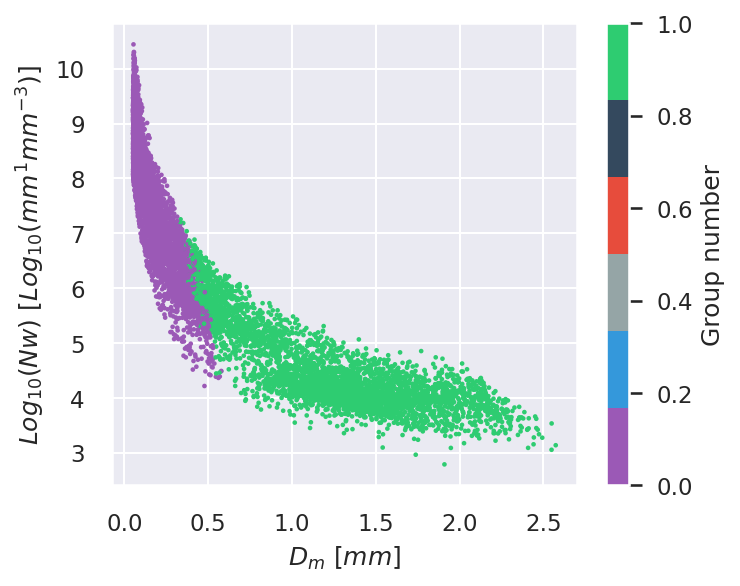

In [95]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["mean_shift"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

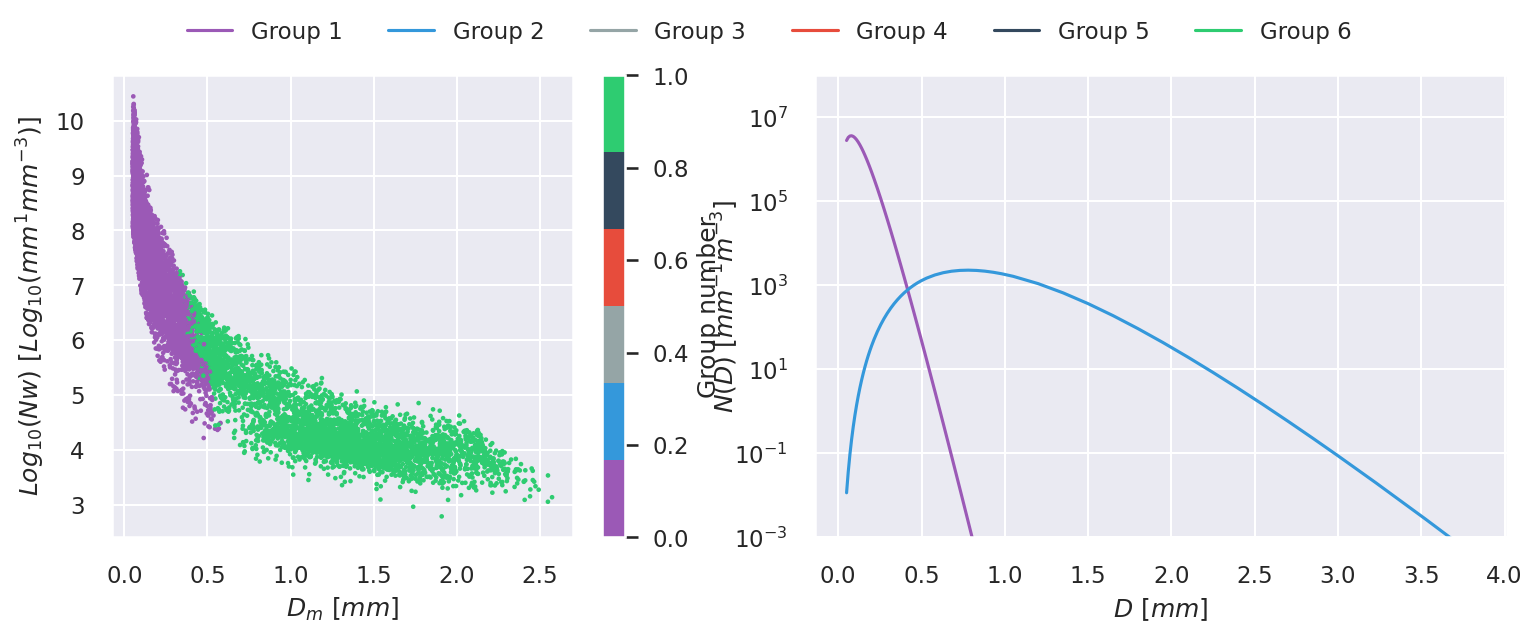

In [96]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['mean_shift'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['mean_shift'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [97]:
model = OPTICS(eps=0.8, min_samples=10)
# fit model and predict clusters
df['optics']= model.fit_predict(X)

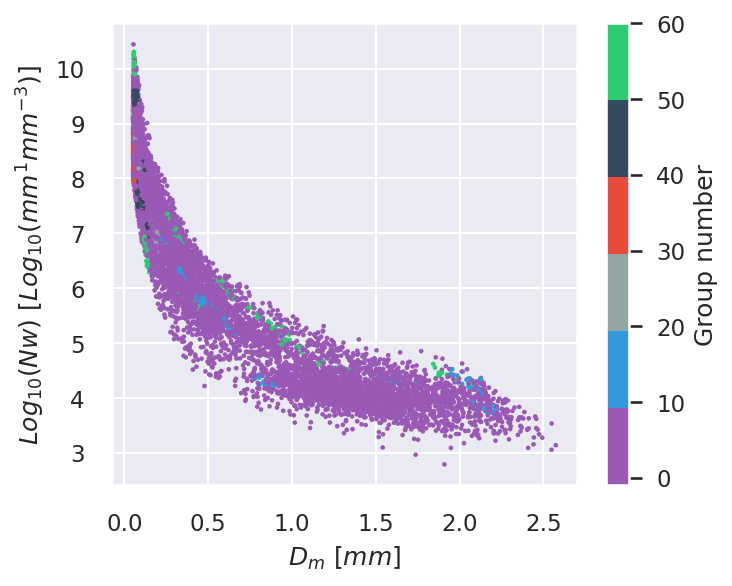

In [98]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["optics"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

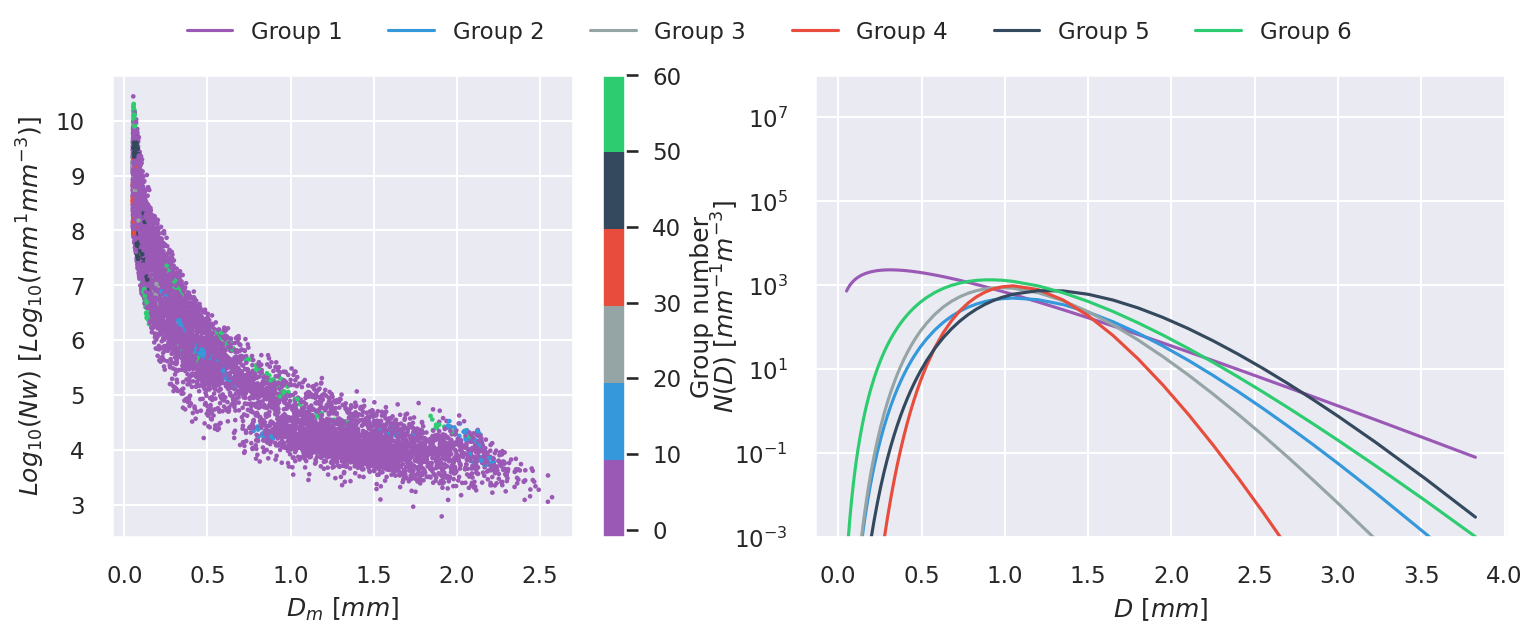

In [100]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['optics'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['optics'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    try:
        df_sub = df[df['optics'] == i]
        mu = df_sub['mu'].mean()
        dm = df_sub['dm'].mean()
        nw = 10 ** (df_sub['log10_nw'].mean())
        gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
        ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
    except IndexError:
        pass
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [101]:
model = SpectralClustering(n_clusters=6)
# fit model and predict clusters
df['spectral'] = model.fit_predict(X)
# retrieve unique clusters


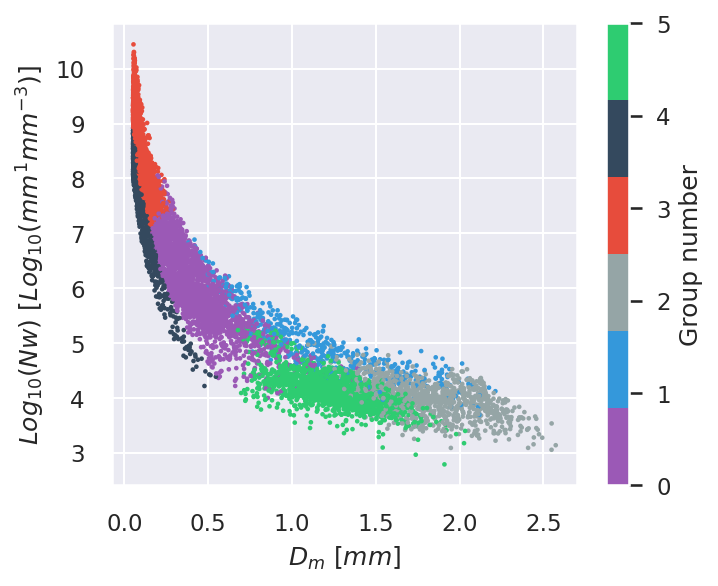

In [102]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["spectral"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

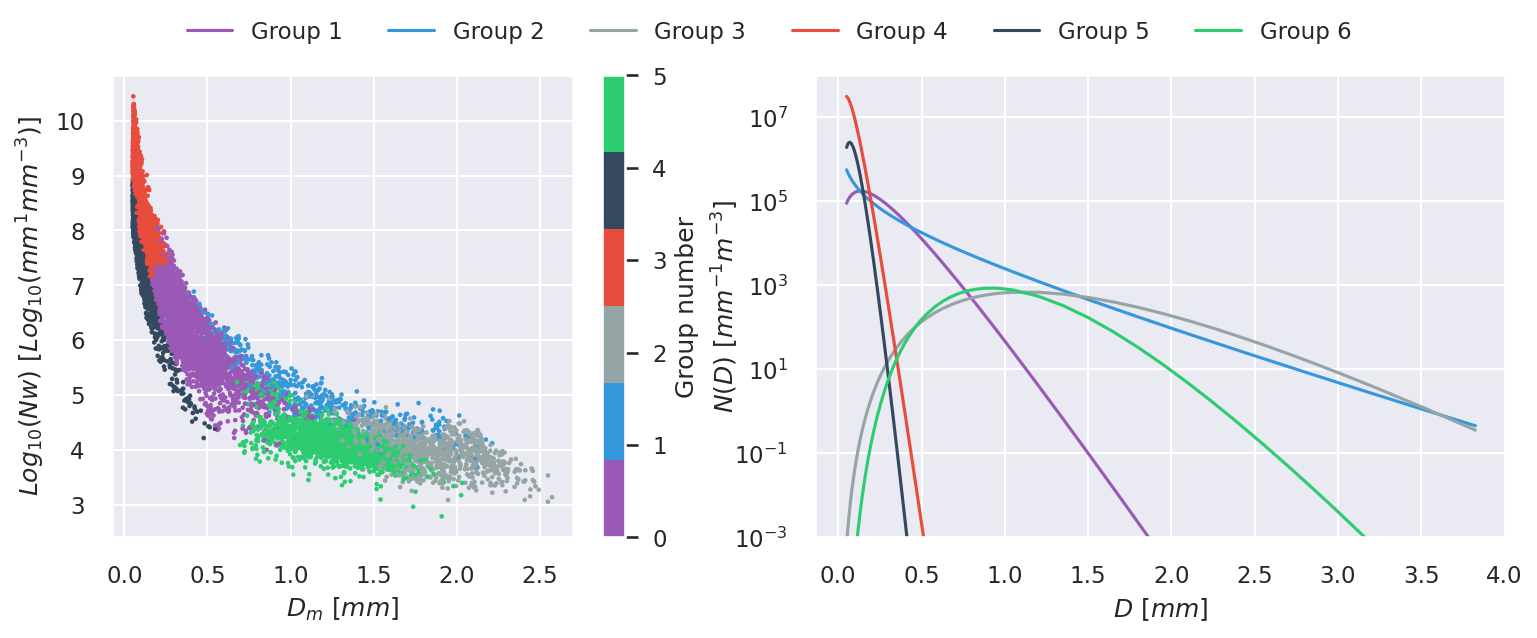

In [103]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['spectral'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['spectral'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['spectral'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [104]:
from sklearn.mixture import GaussianMixture

In [105]:
model = GaussianMixture(n_components=6)
# fit the model
model.fit(X)
# assign a cluster to each example
df['gaussian'] = model.predict(X)

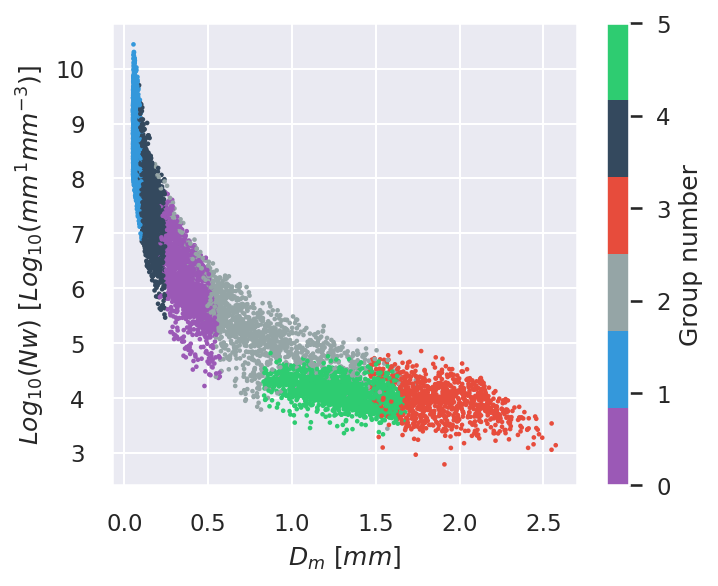

In [106]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["gaussian"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

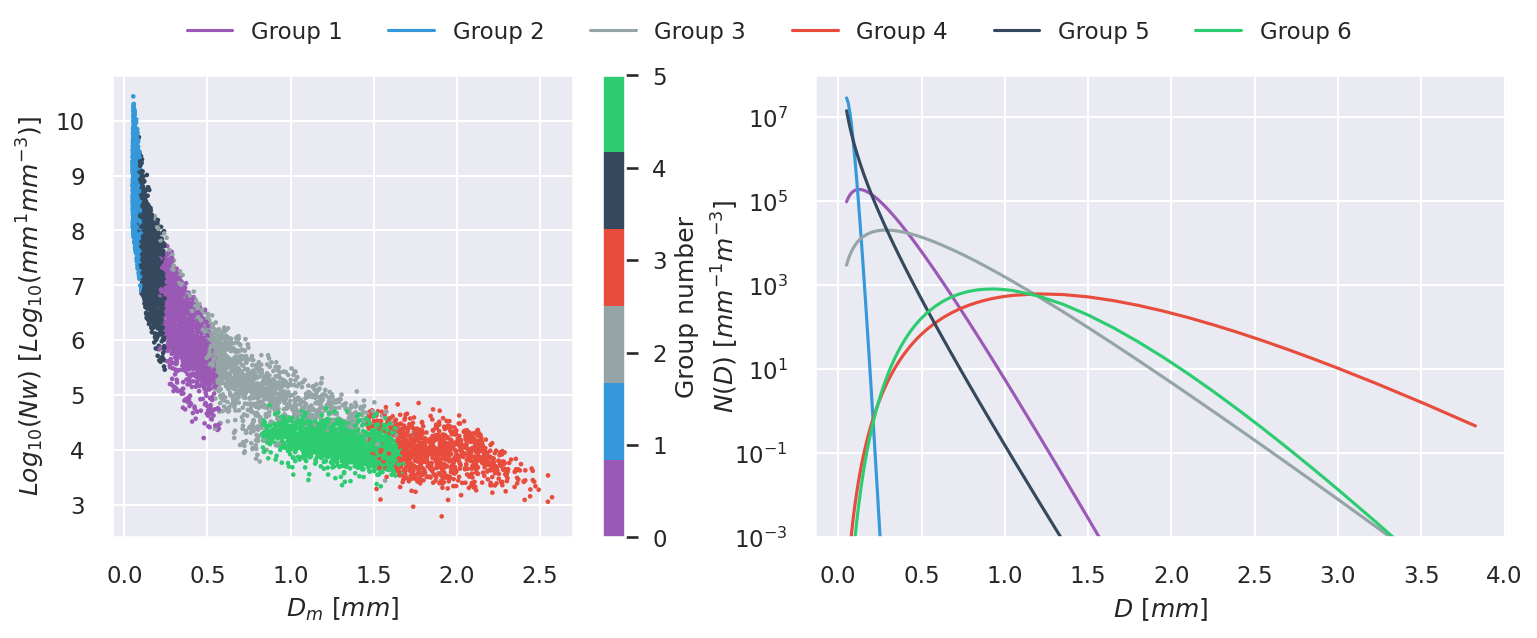

In [107]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['gaussian'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['gaussian'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['gaussian'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [108]:
model = AgglomerativeClustering(n_clusters=6).fit(X)
df['agg_clus'] = model.labels_

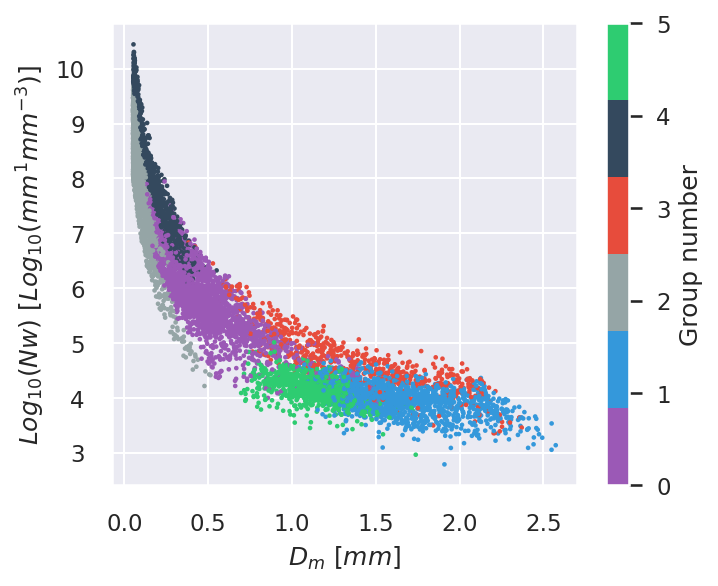

In [109]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df["agg_clus"], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

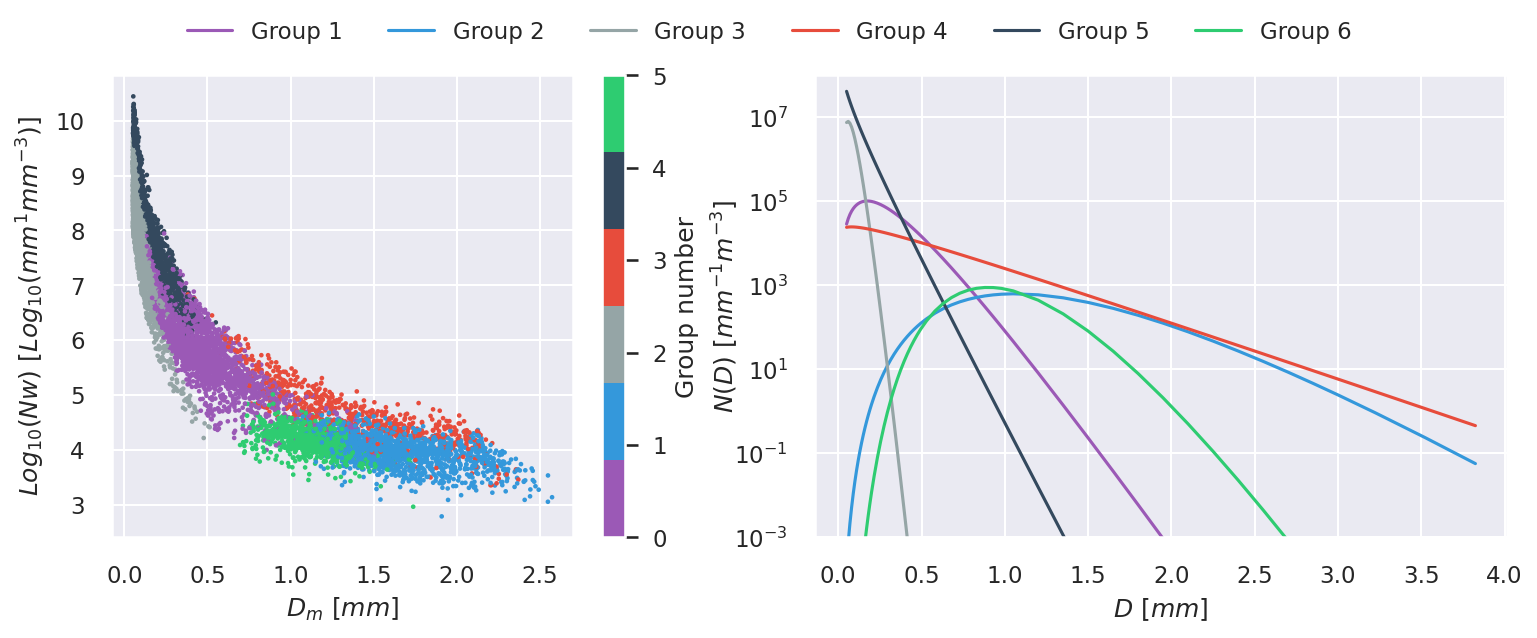

In [111]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['agg_clus'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['agg_clus'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['agg_clus'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

In [112]:
from sklearn.manifold import TSNE

In [113]:
tsne = TSNE(n_components=3, random_state=42)
df[['TSNE1', 'TSNE2', "TSNE3"]] = tsne.fit_transform(X)
tsne.kl_divergence_

0.8798892498016357

In [1]:
import plotly.express as px
fig = px.scatter_3d(df, x='TSNE1', y='TSNE2', z='TSNE3', color='dbz_t_ku',
             width=800, height=800)
fig.update_traces(marker_size = 4)
fig.show()

NameError: name 'df' is not defined

In [115]:
tsne = TSNE(n_components=2, random_state=42)
df[['tsne1', 'tsne2']] = tsne.fit_transform(X)
tsne.kl_divergence_

0.9996639490127563

In [ ]:

fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['tsne1'], df['tsne2'], c=df['spectral'], s=1, cmap=my_cmap6)
ax.set_xlabel("$T-SNE1$")
ax.set_ylabel("$T-SNE1$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
pca = PCA(0.95)
df[['pca1', 'pca2', "pca3"]]  = pca.fit_transform(X)

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='pca1', y='pca2', z='pca3',
              color='kmeans_6', width=800, height=800, color_discrete_map=my_cmap6)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=2, metric='euclidean')
df[["UM1", "UM2"]] = reducer.fit_transform(X)

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['UM1'], df['UM2'], c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.1, n_components=3, metric='euclidean')
df[["UM1", "UM2", "UM3"]] = reducer.fit_transform(X)

In [ ]:
fig = px.scatter_3d(df, x='UM1', y='UM2', z='UM3',
              color='kmeans_6', width=800, height=800, color_discrete_map=my_cmap6)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
from sklearn import manifold

iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(X)
df[["ISO1", "ISO2"]] = iso.transform(X)

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['ISO1'], df['ISO2'], c=df['kmeans_6'], s=1, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
iso = manifold.Isomap(n_neighbors=12, n_components=3)
iso.fit(X)
df[["ISO1", "ISO2", "ISO3"]] = iso.transform(X)

In [ ]:
fig = px.scatter_3d(df, x='ISO1', y='ISO2', z='ISO3',
              color='kmeans_6', width=800, height=800, color_discrete_map=my_cmap6)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
n_c = 6
kmeans = KMeans(n_clusters=n_c)
kmeans.fit(df[["ISO1", "ISO2", "ISO3"]])
df['kmeans_iso'] = kmeans.labels_

In [ ]:
fig,  ax = plt.subplots(figsize=(5,4), dpi=150)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_iso'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
fig.colorbar(sc, ax=ax, label="Group number")

In [ ]:
df.columns

In [ ]:
fig, (ax1, ax) = plt.subplots(1, 2, figsize=(11,4), dpi=150)

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e8)
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
dm_t, sigma_t, nw_t, r_t, nt_t, lwc_t, group = [], [], [], [], [], [], []
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].mean()
    dm = df_sub['dm'].mean()
    nw = 10 ** (df_sub['log10_nw'].mean())
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    dm_t.append(df_sub['dm_T'].mean())
    sigma_t.append(df_sub['sigma_T'].mean())
    nw_t.append(df_sub['log10_nw_T'].mean())
    r_t.append(df_sub['logr_T'].mean())
    nt_t.append(df_sub['lognt_T'].mean())
    lwc_t.append(df_sub['loglwc_T'].mean())
    group.append(i+1)
    ax1.plot(d, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)

df_t = pd.DataFrame(data=np.squeeze(np.dstack([dm_t, sigma_t, nw_t, r_t, nt_t, lwc_t, group])), index=[f"Group {i}" for i in range(1, 7)], 
                   columns=['Dm', 'sigma', 'Log10(Nw)', 'Log10(R)', "Log10(Nt)", "Log10(LWC)", "Group"]).T
for idx, i in enumerate(df_t.columns):
    ax.plot(df_t[i][:-1], c=colors6[idx] )
ticks = ax.get_xticks(minor=False)
ax.set_ylabel("$Normalized \ mean$", labelpad=1)
ax.set_xlabel("$Parameter$")
ax.set_xticklabels([r'$Dm$', '$\sigma$', '$Log10(N_w)$', '$Log10(R)$', "$Log10(N_t)$", "$Log10(LWC)$", ], size=8)

In [ ]:
ticks

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df, x='dbz_t_ku', y='dfr', z='r',
             width=800, height=800)
fig.update_traces(marker_size = 4)
fig.show()

In [ ]:
df_res = df.set_index(df['time'])

In [ ]:
df